In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from estimation_forecast_functions import DataCleaner_SGD, BMSM_Forecaster_MLE, GARCH_Forecaster_MLE, FIGARCH_Forecaster, pre_whitening, LMSM_Estimator_GMM
from numpy.linalg import solve
from numpy.linalg import cholesky as np_cholesky
from scipy.linalg import toeplitz, solve_triangular
from scipy.stats import chi2 
from scipy.special import polygamma
from autograd import grad
import autograd.numpy as anp
import statsmodels.api as sm
import pandas_datareader.data as web
import datetime as dt
import numdifftools as nd
from statsmodels.tsa.vector_ar.var_model import VAR
from covariance import pwrc_long_run_cov
import yfinance as yf

# LMSM

## Validate estimations with simulated data

We have lognormal 0.05 (k bar = 10) and 0.1 (k bar = 15) parameters to consider. 

Multiply returns by 100 first to get percent terms and then after we do pre-whitening and estimation. 

In [4]:
train_log_returns_005 = np.load("/Users/alexvillamartin/Documents/MSc Diss/Code/all_paths_Lmsm.npz")['r'] * 100
npaths = 400
true_lambda_005 = 0.05
true_sigma_bar_005 = 1.0

In [5]:
lambdas_005 = []
sigma_bars_005 = []

for i in range(npaths):

    if i % 50 == 0:
        print(f"Processing path {i+1}/{npaths}")

    #e_i, mu_i, rho_i = pre_whitening(train_log_returns_005[:, i]) simulation is already pre-whitened returns

    initial_params = np.array([0.1, np.std(train_log_returns_005[:, i])])  

    estimator_i = LMSM_Estimator_GMM(train_returns=train_log_returns_005[:, i],
                                    initial_params=initial_params,
                                    lags=[1, 5, 10, 20], 
                                    kbar=10, 
                                    b=2.0, 
                                    gamma_kbar=0.5, 
                                    max_iter=50, 
                                    param_tol=1e-6,
                                    W_tol=1e-4)

    lamb_hat, sigma_hat, res, W = estimator_i.estimate_lmsm()
    lambdas_005.append(lamb_hat)
    sigma_bars_005.append(sigma_hat)

Processing path 1/400
Iteration 1: param_err=0.099999, W_err=0.887675
Iteration 2: param_err=0.038741, W_err=0.000000
Iteration 3: param_err=0.000113, W_err=0.000000
Iteration 4: param_err=0.000051, W_err=0.000000
Iteration 5: param_err=0.000023, W_err=0.000000
Iteration 6: param_err=0.000010, W_err=0.000000
Iteration 7: param_err=0.000004, W_err=0.000000
Iteration 8: param_err=0.000002, W_err=0.000000
Iteration 9: param_err=0.000000, W_err=0.000000
Converged after 9 iterations with param_err=0.000000, W_err=0.000000
Final estimates: lambda_hat = 0.038749012192989804, sigma_bar = 0.924661
Iteration 1: param_err=0.045613, W_err=0.878696
Iteration 2: param_err=0.005279, W_err=0.000000
Iteration 3: param_err=0.000083, W_err=0.000000
Iteration 4: param_err=0.000017, W_err=0.000000
Iteration 5: param_err=0.000002, W_err=0.000000
Iteration 6: param_err=0.000000, W_err=0.000000
Converged after 6 iterations with param_err=0.000000, W_err=0.000000
Final estimates: lambda_hat = 0.059613100589435

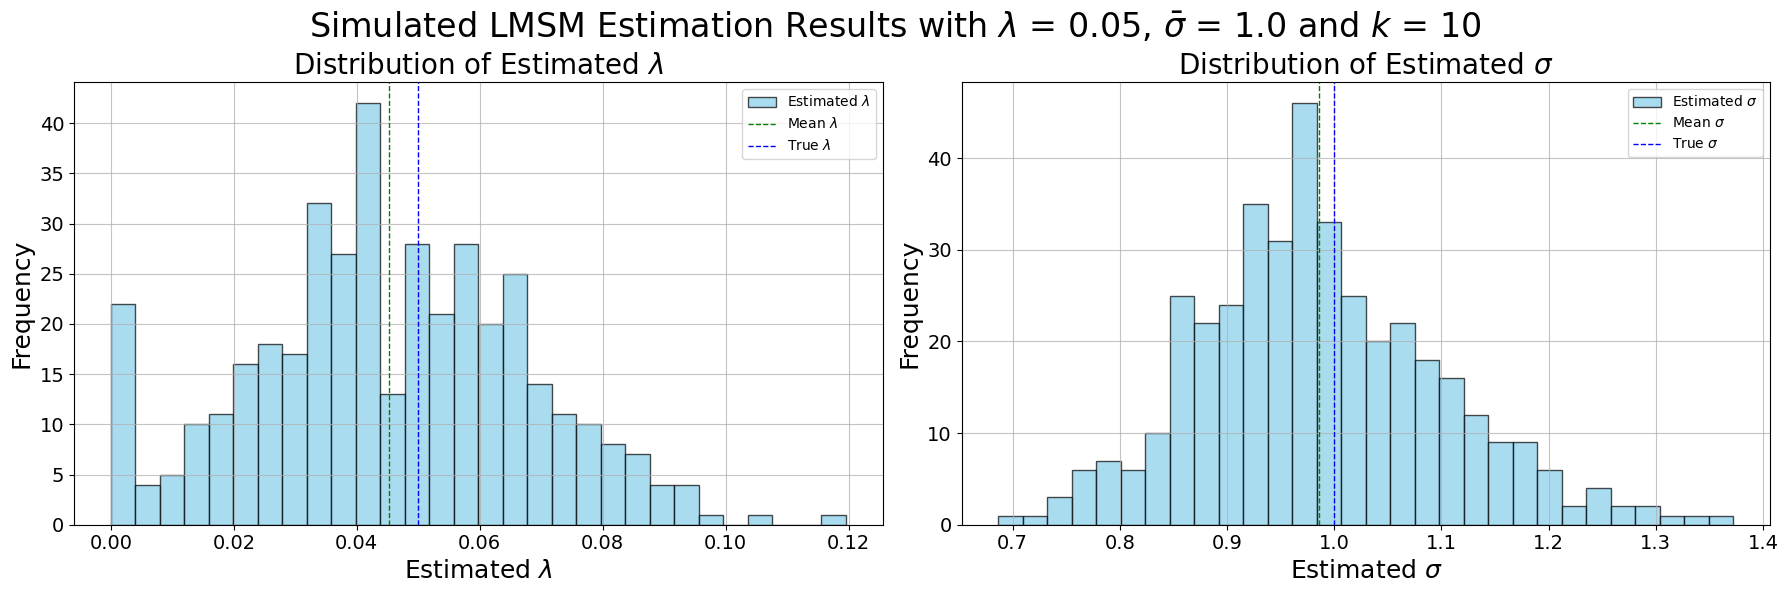

In [9]:
mean_lambda_005 = np.mean(lambdas_005)
mean_sigma_005 = np.mean(sigma_bars_005)


plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(lambdas_005, bins=30, alpha=0.7, label=r'Estimated $\lambda$', color = 'skyblue', edgecolor='black')
plt.axvline(mean_lambda_005, color='green', linestyle='dashed', linewidth=1, label=r'Mean $\lambda$')
plt.axvline(true_lambda_005, color='blue', linestyle='dashed', linewidth=1, label=r'True $\lambda$')
plt.xlabel(r'Estimated $\lambda$', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title(r'Distribution of Estimated $\lambda$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.75)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(sigma_bars_005, bins=30, alpha=0.7, label=r'Estimated $\sigma$', color = 'skyblue', edgecolor='black')
plt.axvline(mean_sigma_005, color='green', linestyle='dashed', linewidth=1, label=r'Mean $\sigma$')
plt.axvline(true_sigma_bar_005, color='blue', linestyle='dashed', linewidth=1, label=r'True $\sigma$')
plt.xlabel(r'Estimated $\sigma$', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title(r'Distribution of Estimated $\sigma$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid( alpha=0.75)
plt.legend()

plt.tight_layout()
plt.suptitle(fr'Simulated LMSM Estimation Results with $\lambda$ = {true_lambda_005}, $\bar{{\sigma}}$ = {true_sigma_bar_005} and $k$ = 10', fontsize=24)
plt.subplots_adjust(top=0.86) 
plt.savefig('/Users/alexvillamartin/Documents/MSc Diss/plots_aug/lmsm_estimation_results_005_lambd_k_10.png')
plt.show()

In [7]:
print(f"Summary results for LMSM Estimation with k=10 and lambda = {true_lambda_005} and sigma_bar = {true_sigma_bar_005}")
print(f"Mean estimated lambda: {mean_lambda_005}, Mean estimated sigma: {mean_sigma_005}")

rmse_lamb = np.sqrt(np.mean((np.array(lambdas_005) - true_lambda_005)**2))
rmse_sigma = np.sqrt(np.mean((np.array(sigma_bars_005) - true_sigma_bar_005)**2))
print(f"RMSE for lambda: {rmse_lamb}, RMSE for sigma: {rmse_sigma}")

Summary results for LMSM Estimation with k=10 and lambda = 0.05 and sigma_bar = 1.0
Mean estimated lambda: 0.045288608878258876, Mean estimated sigma: 0.9860595026228952
RMSE for lambda: 0.023058518530934165, RMSE for sigma: 0.1140952310294957


In [10]:
train_log_returns_01 = np.load("/Users/alexvillamartin/Documents/MSc Diss/Code/all_paths_Lmsm_lamb_0.1.npz")['r'] * 100
npaths = 400
true_lambda_01 = 0.1
true_sigma_bar_01 = 1.0

In [11]:
lambdas_01 = []
sigma_bars_01 = []

for i in range(npaths):

    if i % 50 == 0:
        print(f"Processing path {i+1}/{npaths}")

    initial_params = np.array([0.1, np.std(train_log_returns_01[:, i])])  

    estimator_i = LMSM_Estimator_GMM(train_returns=train_log_returns_01[:, i],
                                    initial_params=initial_params,
                                    lags=[1, 5, 10, 20], 
                                    kbar=15, 
                                    b=2.0, 
                                    gamma_kbar=0.5, 
                                    max_iter=50, 
                                    param_tol=1e-6,
                                    W_tol=1e-4)

    lamb_hat, sigma_hat, res, W = estimator_i.estimate_lmsm()
    lambdas_01.append(lamb_hat)
    sigma_bars_01.append(sigma_hat)

Processing path 1/400
Iteration 1: param_err=0.045947, W_err=0.914134
Iteration 2: param_err=0.020302, W_err=0.000000
Iteration 3: param_err=0.000103, W_err=0.000000
Iteration 4: param_err=0.000098, W_err=0.000000
Iteration 5: param_err=0.000093, W_err=0.000000
Iteration 6: param_err=0.000089, W_err=0.000000
Iteration 7: param_err=0.000085, W_err=0.000000
Iteration 8: param_err=0.000081, W_err=0.000000
Iteration 9: param_err=0.000077, W_err=0.000000
Iteration 10: param_err=0.000074, W_err=0.000000
Iteration 11: param_err=0.000070, W_err=0.000000
Iteration 12: param_err=0.000067, W_err=0.000000
Iteration 13: param_err=0.000064, W_err=0.000000
Iteration 14: param_err=0.000061, W_err=0.000000
Iteration 15: param_err=0.000058, W_err=0.000000
Iteration 16: param_err=0.000055, W_err=0.000000
Iteration 17: param_err=0.000053, W_err=0.000000
Iteration 18: param_err=0.000050, W_err=0.000000
Iteration 19: param_err=0.000048, W_err=0.000000
Iteration 20: param_err=0.000046, W_err=0.000000
Iterati

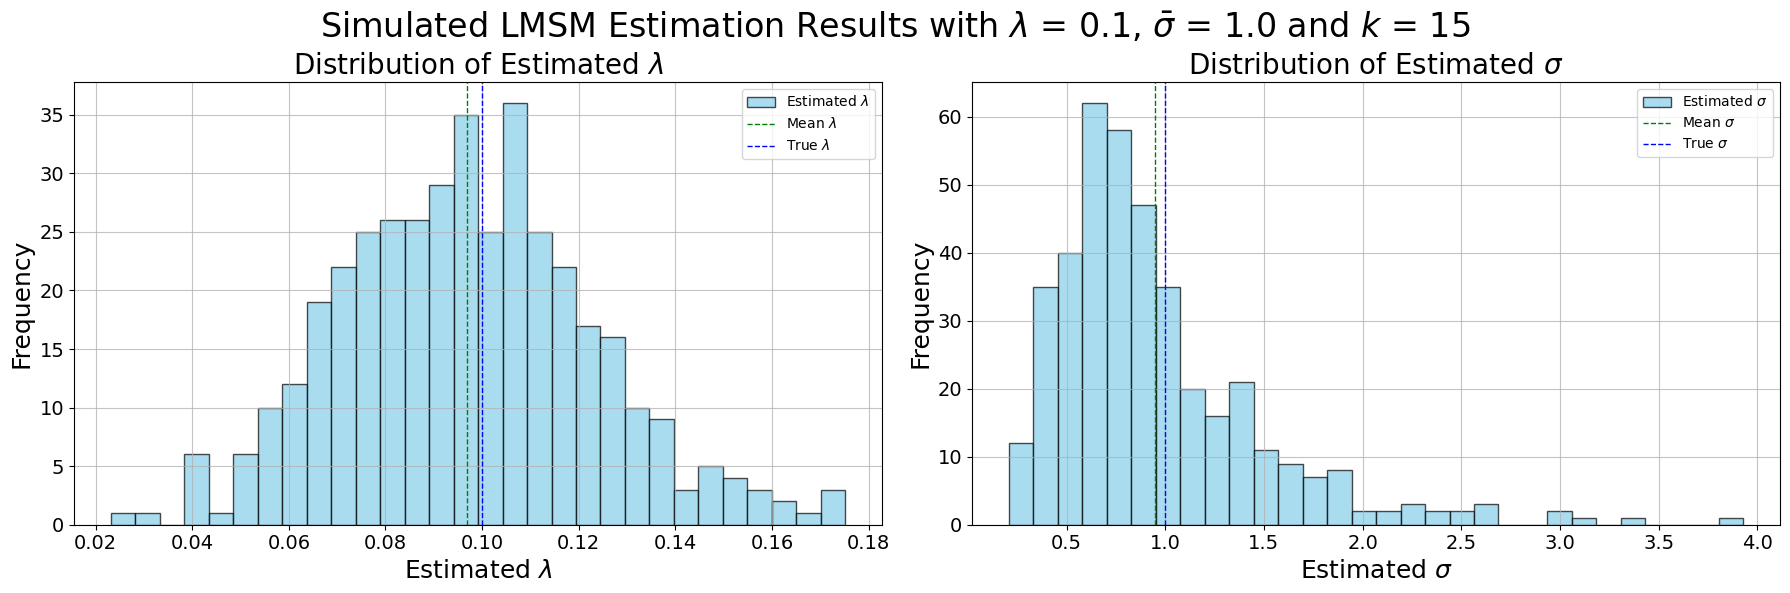

In [15]:
mean_lambda_01 = np.mean(lambdas_01)
mean_sigma_01 = np.mean(sigma_bars_01)


plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(lambdas_01, bins=30, alpha=0.7, label=r'Estimated $\lambda$', color = 'skyblue', edgecolor='black')
plt.axvline(mean_lambda_01, color='green', linestyle='dashed', linewidth=1, label=r'Mean $\lambda$')
plt.axvline(true_lambda_01, color='blue', linestyle='dashed', linewidth=1, label=r'True $\lambda$')
plt.xlabel(r'Estimated $\lambda$', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title(r'Distribution of Estimated $\lambda$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.75)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(sigma_bars_01, bins=30, alpha=0.7, label=r'Estimated $\sigma$', color = 'skyblue', edgecolor='black')
plt.axvline(mean_sigma_01, color='green', linestyle='dashed', linewidth=1, label=r'Mean $\sigma$')
plt.axvline(true_sigma_bar_01, color='blue', linestyle='dashed', linewidth=1, label=r'True $\sigma$')
plt.xlabel(r'Estimated $\sigma$', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title(r'Distribution of Estimated $\sigma$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid( alpha=0.75)
plt.legend()

plt.tight_layout()
plt.suptitle(fr'Simulated LMSM Estimation Results with $\lambda$ = {true_lambda_01}, $\bar{{\sigma}}$ = {true_sigma_bar_01} and $k$ = 15', fontsize=24)
plt.subplots_adjust(top=0.86) 
plt.savefig('/Users/alexvillamartin/Documents/MSc Diss/plots_aug/lmsm_estimation_results_01_lambd_k_15.png')
plt.show()

In [14]:
print(f"Summary results for LMSM Estimation with k=15 and lambda = {true_lambda_01} and sigma_bar = {true_sigma_bar_01}")
print(f"Mean estimated lambda: {mean_lambda_01}, Mean estimated sigma: {mean_sigma_01}")

rmse_lamb = np.sqrt(np.mean((np.array(lambdas_01) - true_lambda_01)**2))
rmse_sigma = np.sqrt(np.mean((np.array(sigma_bars_01) - true_sigma_bar_01)**2))
print(f"RMSE for lambda: {rmse_lamb}, RMSE for sigma: {rmse_sigma}")

Summary results for LMSM Estimation with k=15 and lambda = 0.1 and sigma_bar = 1.0
Mean estimated lambda: 0.09697587223215771, Mean estimated sigma: 0.9469525169448104
RMSE for lambda: 0.026398603092452903, RMSE for sigma: 0.533776731422498


## Use LMSM on empirical data

Check a couple of the Lux 2008 paper results to be sure, then try on our EUR SGD currencies. 

In [58]:
def get_lux_series(ticker, inv = False):

    start_lux = dt.datetime(1979, 1, 1)
    end_lux = dt.datetime(1996, 12, 31)
    
    df = web.DataReader(ticker, 'fred', start_lux, end_lux)

    if inv:
        df = 1 / df
    
    df.dropna(inplace=True)
    
    df['r'] = np.log(df[ticker]).diff()
    r_values = df['r'].values
    r_values = r_values[~np.isnan(r_values)]
    
    return r_values * 100

In [17]:
ticker_yen = 'DEXJPUS'
ticker_gpb = 'DEXUSUK'
ticker_cad = 'DEXCAUS'
ticker_chf = 'DEXSZUS'

train_log_returns_yen = get_lux_series(ticker_yen)
train_log_returns_gpb = get_lux_series(ticker_gpb, inv=True)
train_log_returns_cad = get_lux_series(ticker_cad)
train_log_returns_chf = get_lux_series(ticker_chf)

e_yen, _, _ = pre_whitening(train_log_returns_yen)
e_gbp, _, _ = pre_whitening(train_log_returns_gpb)
e_cad, _, _ = pre_whitening(train_log_returns_cad)
e_chf, _, _ = pre_whitening(train_log_returns_chf)

In [18]:
def get_lux_lmsm_gmm_estimates(e):

    initial_params = np.array([0.5, 1.0])  

    estimator = LMSM_Estimator_GMM(train_returns=e,
                                    initial_params=initial_params,
                                    lags=[1, 5, 10, 20], 
                                    kbar=10, 
                                    b=2.0, 
                                    gamma_kbar=0.5, 
                                    max_iter=50, 
                                    param_tol=1e-6,
                                    W_tol=1e-4)

    lamb_hat, sigma_hat, res, W = estimator.estimate_lmsm()

    standard_errors = estimator.get_standard_errors()

    #j_stat, j_prob = estimator.get_j_prob_inefficient()

    jstat, j_eff = estimator.get_j_prob()

    return lamb_hat, sigma_hat, standard_errors, j_eff, jstat

In [19]:
lambda_yen, sigma_bar_yen, se_yen, j_prob_yen, j_stat_yen = get_lux_lmsm_gmm_estimates(e_yen)
lambda_cad, sigma_bar_cad, se_cad, j_prob_cad, j_stat_cad = get_lux_lmsm_gmm_estimates(e_cad)
lambda_gbp, sigma_bar_gbp, se_gbp, j_prob_gbp, j_stat_gbp = get_lux_lmsm_gmm_estimates(e_gbp)
lambda_chf, sigma_bar_chf, se_chf, j_prob_chf, j_stat_chf = get_lux_lmsm_gmm_estimates(e_chf)

print(f"Estimated parameters for Yen: lambda = {lambda_yen}, sigma_bar = {sigma_bar_yen} with SE[lambda, sigma_bar] = {se_yen} and J-Statistic p-value = {j_prob_yen}")
print(f"Estimated parameters for CAD: lambda = {lambda_cad}, sigma_bar = {sigma_bar_cad} with SE[lambda, sigma_bar] = {se_cad} and J-Statistic p-value = {j_prob_cad}")
print(f"Estimated parameters for GBP: lambda = {lambda_gbp}, sigma_bar = {sigma_bar_gbp} with SE[lambda, sigma_bar] = {se_gbp} and J-Statistic p-value = {j_prob_gbp}")
print(f"Estimated parameters for CHF: lambda = {lambda_chf}, sigma_bar = {sigma_bar_chf} with SE[lambda, sigma_bar] = {se_chf} and J-Statistic p-value = {j_prob_chf}")

Iteration 1: param_err=0.436528, W_err=0.855150
Iteration 2: param_err=0.009423, W_err=0.000000
Iteration 3: param_err=0.000000, W_err=0.000000
Converged after 3 iterations with param_err=0.000000, W_err=0.000000
Final estimates: lambda_hat = 0.06958180006442082, sigma_bar = 0.645941
Iteration 1: param_err=0.736221, W_err=6.389576
Iteration 2: param_err=0.012353, W_err=0.000000
Iteration 3: param_err=0.000000, W_err=0.000000
Converged after 3 iterations with param_err=0.000000, W_err=0.000000
Final estimates: lambda_hat = 0.04537562838218095, sigma_bar = 0.261887
Iteration 1: param_err=0.356183, W_err=0.860710
Iteration 2: param_err=0.094623, W_err=0.000000
Iteration 3: param_err=0.000002, W_err=0.000000
Iteration 4: param_err=0.000000, W_err=0.000000
Converged after 4 iterations with param_err=0.000000, W_err=0.000000
Final estimates: lambda_hat = 0.04919399188474263, sigma_bar = 0.680547
Iteration 1: param_err=0.499999, W_err=0.848165
Iteration 2: param_err=0.005865, W_err=0.000000
I

## Forecasts + Estimation of SGD / EUR

Use our tickers.

In [134]:
daily_log_returns = pd.read_parquet("SGD_USD_Daily_matched.parquet") * 100
N = len(daily_log_returns)

train_log_returns = daily_log_returns.iloc[:int(N * 0.5)]
train_log_returns = train_log_returns[train_log_returns != 0].dropna()
test_log_returns = daily_log_returns.iloc[int(N * 0.5):]

train_e, _, _ = pre_whitening(train_log_returns.values.reshape(-1,))
initial_params = [0.5, np.std(train_log_returns.values)]

In [146]:
test = LMSM_Estimator_GMM_N(train_returns=train_log_returns.values.reshape(-1,),
                        initial_params=np.array([0.1]),
                        lags=[2, 5, 10, 20],
                        kbar=10,
                        b=2.0,
                        gamma_kbar=0.5,
                        max_iter=1,
                        param_tol=1e-6,
                        W_tol=1e-4)

test_lamb, test_sigma, res, W= test.estimate_lmsm()

se = test.get_standard_errors()

print(se)

j_stat, j_prob = test.get_j_prob()

print(f"J-Statistic: {j_stat}, p-value: {j_prob}")

Iteration 1: param_err=0.099999, W_err=0.747271
Did not converge after 1 iterations with param_err=0.099999, W_err=0.747271
Final estimates: lambda_hat = 1e-06, sigma_bar = 0.327698


/var/folders/ws/xbf0f9zj4qxc6drt1bjn4lg40000gn/T/ipykernel_25401/311171868.py:124: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_t[col]   = xi_t_T * xi_tpT_T - theoretical[2*idx]
/var/folders/ws/xbf0f9zj4qxc6drt1bjn4lg40000gn/T/ipykernel_25401/311171868.py:125: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_t[col+1] = (xi_t_T**2) * (xi_tpT_T**2) - theoretical[2*idx + 1]


0.007540683099583419
J-Statistic: 5043.717920466853, p-value: 0.0


In [132]:
train_e[train_e == 0]

array([], dtype=float64)

# Forecasting RV using BMSM

In [21]:
m0s = []
sigma_bars = []


for i in range(npaths):

    if i % 50 == 0:
        print(f"Processing path {i+1}/{npaths}")

    bmsm_forecasts = BMSM_Forecaster_MLE(
        initial_params=initial_params,
        train_data=r[:, i].flatten(),
        test_data=test_log_returns.values.flatten(),
        test_realised_variance=test_realised_variance.values.flatten(),
        kbar=8,
        H=H, 
        scale=100, 
        b = 2.0, 
        gamma_kbar=0.5,
        percent_space=True)

    result, logL = bmsm_forecasts.estimate_msm_params() 

    m0s.append(result.x[0])
    sigma_bars.append(result.x[1])

Processing path 1/400
Estimated parameters: m0=1.400718e+00, sigma_bar=9.050448e-01
Final log-likelihood: -2.833811e+03
Estimated parameters: m0=1.399111e+00, sigma_bar=1.110023e+00
Final log-likelihood: -3.228469e+03
Estimated parameters: m0=1.429887e+00, sigma_bar=1.009204e+00
Final log-likelihood: -2.805232e+03
Estimated parameters: m0=1.405504e+00, sigma_bar=1.047769e+00
Final log-likelihood: -3.033552e+03
Estimated parameters: m0=1.424005e+00, sigma_bar=1.029459e+00
Final log-likelihood: -2.817285e+03
Estimated parameters: m0=1.377648e+00, sigma_bar=9.903720e-01
Final log-likelihood: -3.087718e+03
Estimated parameters: m0=1.397414e+00, sigma_bar=7.927975e-01
Final log-likelihood: -2.401966e+03
Estimated parameters: m0=1.403161e+00, sigma_bar=9.036837e-01
Final log-likelihood: -2.827081e+03
Estimated parameters: m0=1.348550e+00, sigma_bar=7.310902e-01
Final log-likelihood: -2.295492e+03
Estimated parameters: m0=1.376531e+00, sigma_bar=9.606518e-01
Final log-likelihood: -3.101031e+0

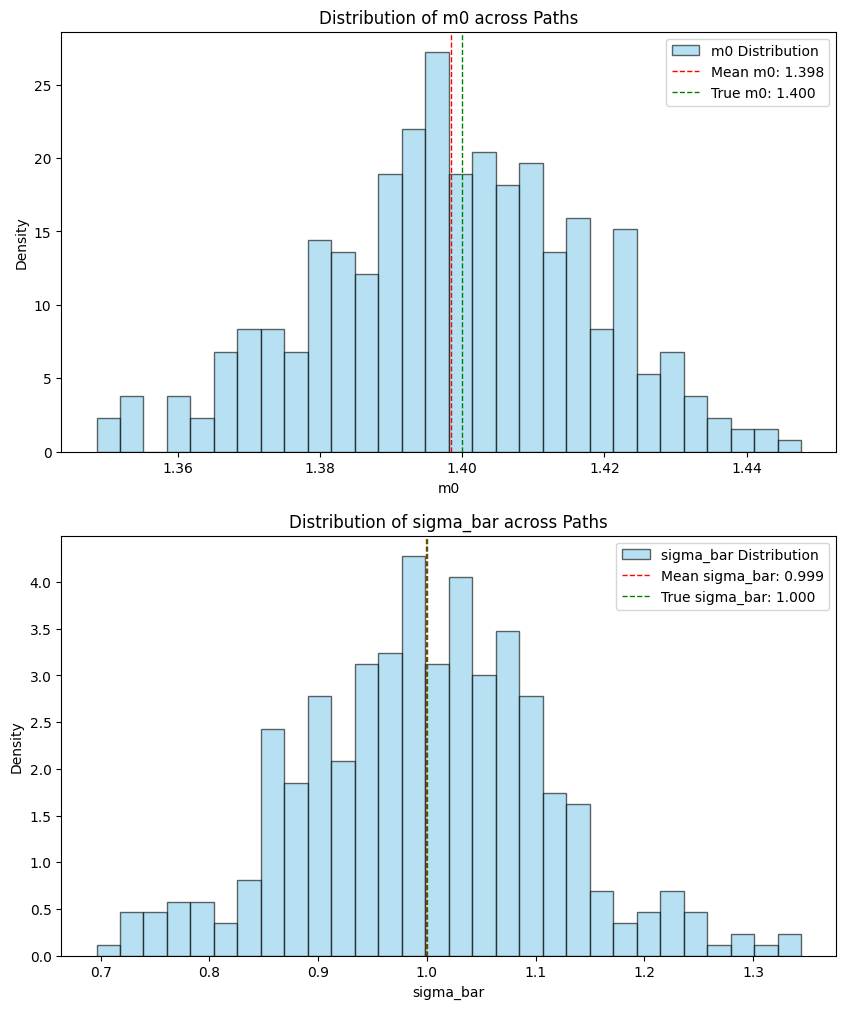

In [29]:
mean_m0 = np.mean(m0s)
mean_sigma_bar = np.mean(sigma_bars)
true_m0 = 1.4
true_sigma_bar = 1.0

plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
plt.hist(m0s, bins=30, density=True, alpha=0.6, color='skyblue', label='m0 Distribution', edgecolor='black')
plt.axvline(mean_m0, color='red', linestyle='dashed', linewidth=1, label=f'Mean m0: {mean_m0:.3f}')
plt.axvline(true_m0, color='green', linestyle='dashed', linewidth=1, label=f'True m0: {true_m0:.3f}')
plt.xlabel('m0')
plt.ylabel('Density')
plt.title('Distribution of m0 across Paths')
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(sigma_bars, bins=30, density=True, alpha=0.6, color='skyblue', label='sigma_bar Distribution', edgecolor='black')
plt.axvline(mean_sigma_bar, color='red', linestyle='dashed', linewidth=1, label=f'Mean sigma_bar: {mean_sigma_bar:.3f}')
plt.axvline(true_sigma_bar, color='green', linestyle='dashed', linewidth=1, label=f'True sigma_bar: {true_sigma_bar:.3f}')
plt.xlabel('sigma_bar')
plt.ylabel('Density')
plt.title('Distribution of sigma_bar across Paths')
plt.legend()    

In [28]:
rmse_m0 = np.sqrt(np.mean((np.array(m0s) - true_m0) ** 2))
rmse_sigma_bar = np.sqrt(np.mean((np.array(sigma_bars) - true_sigma_bar) ** 2))

print(f"RMSE for m0: {rmse_m0:.4f}")
print(f"RMSE for sigma_bar: {rmse_sigma_bar:.4f}")

RMSE for m0: 0.0188
RMSE for sigma_bar: 0.1121


The above is the same as OG GMM paper so we conclude correct.

## Empirical

Need to check forecasting is this different now we use residuals from that OLS. 

In [77]:
def get_lux_bmsm_mle_estimates(Y):

    bmsm_forecasts = BMSM_Forecaster_MLE(
        initial_params=np.array([1.2, np.std(Y)]), 
        train_data=Y,
        test_data=np.ones_like(Y), 
        test_realised_variance=np.ones_like(Y),  
        kbar=8,
        H=20, 
        B = 10,
        scale=1, 
        b = 2.0, 
        gamma_kbar=0.5,
        percent_space=True)

    result, logL = bmsm_forecasts.estimate_msm_params() 

    return result.x[0], result.x[1]  

In [78]:
m0_yen, sigma_bar_yen = get_lux_bmsm_mle_estimates(e_yen)
m0_cad, sigma_bar_cad = get_lux_bmsm_mle_estimates(e_cad)
m0_gbp, sigma_bar_gbp = get_lux_bmsm_mle_estimates(e_gbp)
m0_chf, sigma_bar_chf = get_lux_bmsm_mle_estimates(e_chf)

print(f"Estimated parameters for Yen: m0 = {m0_yen}, sigma_bar = {sigma_bar_yen}")
print(f"Estimated parameters for CAD: m0 = {m0_cad}, sigma_bar = {sigma_bar_cad}")
print(f"Estimated parameters for GBP: m0 = {m0_gbp}, sigma_bar = {sigma_bar_gbp}")
print(f"Estimated parameters for CHF: m0 = {m0_chf}, sigma_bar = {sigma_bar_chf}")

Estimated parameters: m0=1.336259e+00, sigma_bar=6.730023e-01
Final log-likelihood: -4.196874e+03
Estimated parameters: m0=1.309130e+00, sigma_bar=2.422763e-01
Final log-likelihood: 1.960472e+02
Estimated parameters: m0=1.291710e+00, sigma_bar=6.465609e-01
Final log-likelihood: -4.270363e+03
Estimated parameters: m0=1.250640e+00, sigma_bar=7.268825e-01
Final log-likelihood: -5.026579e+03
Estimated parameters for Yen: m0 = 1.3362593861497598, sigma_bar = 0.6730023220384707
Estimated parameters for CAD: m0 = 1.3091302967380167, sigma_bar = 0.24227628403712226
Estimated parameters for GBP: m0 = 1.291709701389054, sigma_bar = 0.6465609305632106
Estimated parameters for CHF: m0 = 1.250640237347165, sigma_bar = 0.7268825409042121


In [35]:
sgd_usd_5m = pd.read_parquet("SGD_USD_5M.parquet")  
cleaner = DataCleaner(sgd_usd_5m, start_hr=2, end_hr=18, unit_test=False) # replace US SG holidays when needed
realised_variance = cleaner.clean_data()
daily_log_returns = pd.read_parquet("SGD_USD_Daily_matched.parquet")
N = len(daily_log_returns)

train_log_returns = daily_log_returns.iloc[:int(N * 0.5)]
test_log_returns = daily_log_returns.iloc[int(N * 0.5):]
test_realised_variance = realised_variance.iloc[int(N * 0.5):]
initial_params = [1.4, np.std(train_log_returns.values *100)]# m0, sigma_bar
H = 20

In [37]:
bmsm_forecasts = BMSM_Forecaster_MLE(
    initial_params=initial_params,
    train_data=train_log_returns.values.flatten(),
    test_data=test_log_returns.values.flatten(),
    test_realised_variance=test_realised_variance.values.flatten(),
    kbar=8,
    H=H, 
    B = 10,
    scale=100, 
    b = 2.0, 
    gamma_kbar=0.5,
    percent_space=True)

mse, R2, realised_vol_H_forecasts, realised_vol_H_true = bmsm_forecasts.compute_forecasts()

Estimated parameters: m0=1.247959e+00, sigma_bar=3.123256e-01
Final log-likelihood: -2.463319e+02


In [35]:
print(f"MSE: {mse}, R2: {R2:.6f}")
print(realised_vol_H_forecasts)
print(realised_vol_H_true)

MSE: 0.7935005470631294, R2: 0.383500
[5.80793682 5.67956793 5.74790532 ... 6.23062837 6.17641372 6.28626684]
[5.78968493 5.75157122 5.68855608 ... 6.12619379 6.12537992 6.25970026]


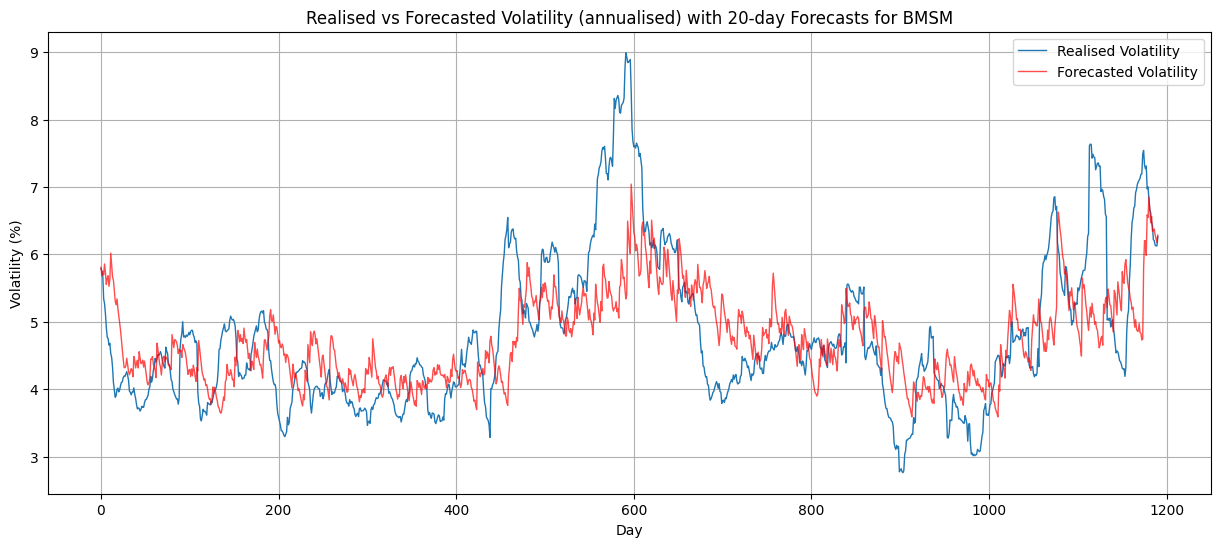

In [36]:
plt.figure(figsize=(15, 6))
plt.plot(realised_vol_H_true, color = 'tab:blue',label='Realised Volatility', linewidth=1)
plt.plot(realised_vol_H_forecasts, color = 'red', label='Forecasted Volatility', linestyle='-', linewidth=1, alpha=0.7)
plt.xlabel('Day')
plt.ylabel('Volatility (%)')
plt.title(f'Realised vs Forecasted Volatility (annualised) with {H}-day Forecasts for BMSM')
plt.grid()
plt.legend()


# Check with YEN against paper

In [341]:
# pip install pandas_datareader
import pandas_datareader.data as web
import datetime as dt

start = dt.datetime(1979, 1, 1)
end   = dt.datetime(1996, 12, 31)

df = web.DataReader('DEXJPUS', 'fred', start, end)


In [ ]:
X = df.copy()
X['r'] = np.log(X['DEXJPUS']).diff()            # this or linear r makes no diff neither does percentage on actual values
X = X[1:]
Y = X['r'].values
Y = Y[~np.isnan(Y)]  
initial_params = np.array([1.2, np.std(Y)]) 

In [ ]:
bmsm_forecasts = BMSM_Forecaster_MLE(
    initial_params=initial_params,
    train_data=Y,
    test_data = None,
    test_realised_variance=None,
    kbar=10,
    H=5, 
    scale=100, 
    b = 2.0, 
    gamma_kbar=0.5,
    percent_space=False)

result, logL = bmsm_forecasts.estimate_msm_params()

Estimated parameters: m0=1.326006e+00, sigma_bar=7.126141e-03
Final log-likelihood: 1.605247e+04


# Forecasting RV using GARCH(1, 1)

In [ ]:
sgd_usd_5m = pd.read_parquet("SGD_USD_5M.parquet")  
cleaner = DataCleaner_SGD(sgd_usd_5m, start_hr=2, end_hr=18, unit_test=False) # replace US SG holidays when needed
realised_variance = cleaner.clean_data()
daily_log_returns = pd.read_parquet("SGD_USD_Daily_matched.parquet")
N = len(daily_log_returns)

train_log_returns = daily_log_returns.iloc[:int(N * 0.5)]
test_log_returns = daily_log_returns.iloc[int(N * 0.5):]
test_realised_variance = realised_variance.iloc[int(N * 0.5):]
initial_params = [1e-6, 0.15, 0.82] # omega, alpha, eta
H = 20

In [ ]:
garch_forecaster = GARCH_Forecaster_MLE(
    train_data=train_log_returns.values.flatten(),
    test_data=test_log_returns.values.flatten(),
    test_realised_variance=test_realised_variance.values.flatten(),
    initial_params=initial_params,
    p=1,
    q=1,
    H=H, 
    scale=100, 
    percent_space=True)

omega, alpha, beta, sigma2_prev = garch_forecaster.estimate_garch()

mse, R2, realised_vol_H_forecasts, realised_vol_H_true = garch_forecaster.forecast_garch()

Estimated parameters: omega=0.0005144802883575586, alpha=0.0506, beta=0.9461
Alpha + Beta = 0.9967
Final log-likelihood = 1707.9430
MSE: 0.8047013769997924, R2: 0.374797


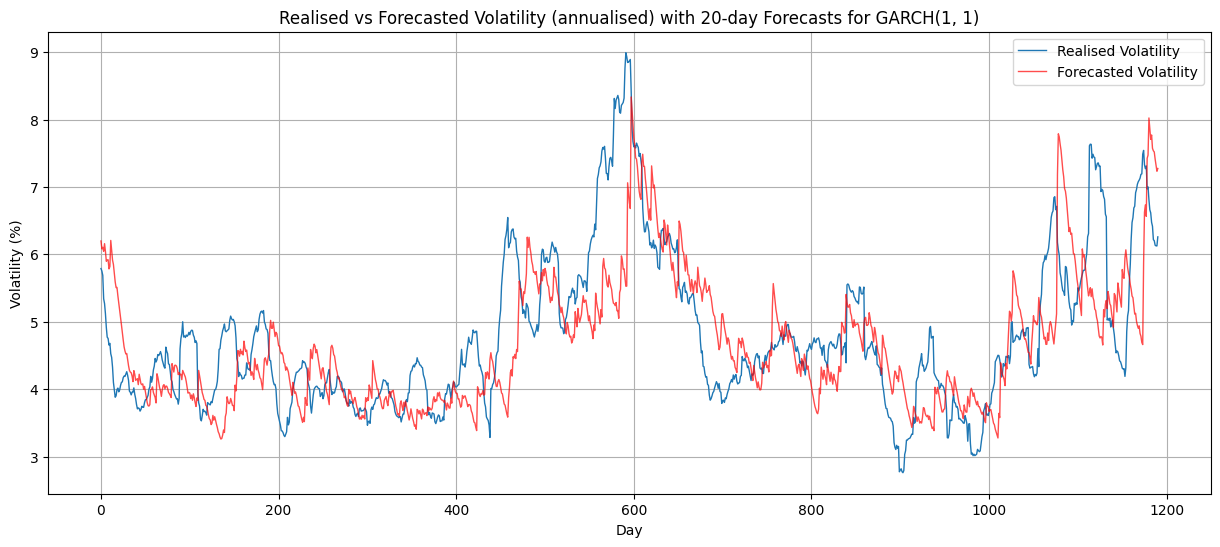

In [32]:
plt.figure(figsize=(15, 6))
plt.plot(realised_vol_H_true, color = 'tab:blue',label='Realised Volatility', linewidth=1)
plt.plot(realised_vol_H_forecasts , color = 'red', label='Forecasted Volatility', linestyle='-', linewidth=1, alpha=0.7)
plt.xlabel('Day')
plt.ylabel('Volatility (%)')
plt.title(f'Realised vs Forecasted Volatility (annualised) with {H}-day Forecasts for GARCH(1, 1)')
plt.grid()
plt.legend()


# Forecasting RV using FIGARCH(1, d, 0)

In [34]:
train_log_returns = np.load('/Users/alexvillamartin/Documents/MSc Diss/Code/all_paths_figarch.npz')['r']
train_log_returns
initial_params = [1e-4, 0.35, 0.15] # omega, d, beta

omegas = []
ds = []
betas = []

for i in range(500):
    figarch_forecaster = FIGARCH_Forecaster(
        train_data=train_log_returns[:, i],
        test_data=test_log_returns.values.flatten(),
        test_realised_variance=test_realised_variance.values.flatten(),
        initial_params=initial_params,
        p=1,
        q=0,
        H=H, 
        M=500, 
        scale=100,
        percent_space=True)

    omega, d, beta, sigma2_prev = figarch_forecaster.estimate_figarch()
    
    omegas.append(omega)
    ds.append(d)
    betas.append(beta)

Estimated parameters: omega=0.008525345190190438, d=0.4690, beta=0.2674
Final log-likelihood = 10886.2587
Estimated parameters: omega=0.007230429785356067, d=0.4398, beta=0.2507
Final log-likelihood = 11666.9345
Estimated parameters: omega=0.00719941643759551, d=0.4693, beta=0.2520
Final log-likelihood = 9463.1560
Estimated parameters: omega=0.010238465374490144, d=0.4373, beta=0.2036
Final log-likelihood = 10360.3647
Estimated parameters: omega=0.010728072819774018, d=0.4590, beta=0.2412
Final log-likelihood = 7721.4080
Estimated parameters: omega=0.008632418150362205, d=0.4597, beta=0.2472
Final log-likelihood = 10588.6836
Estimated parameters: omega=0.007328201591805674, d=0.4902, beta=0.2997
Final log-likelihood = 5271.9959
Estimated parameters: omega=0.007232416426810474, d=0.4803, beta=0.2871
Final log-likelihood = 12945.7761
Estimated parameters: omega=0.009037042393368448, d=0.4454, beta=0.2547
Final log-likelihood = 8729.4141
Estimated parameters: omega=0.007937380238343195, d

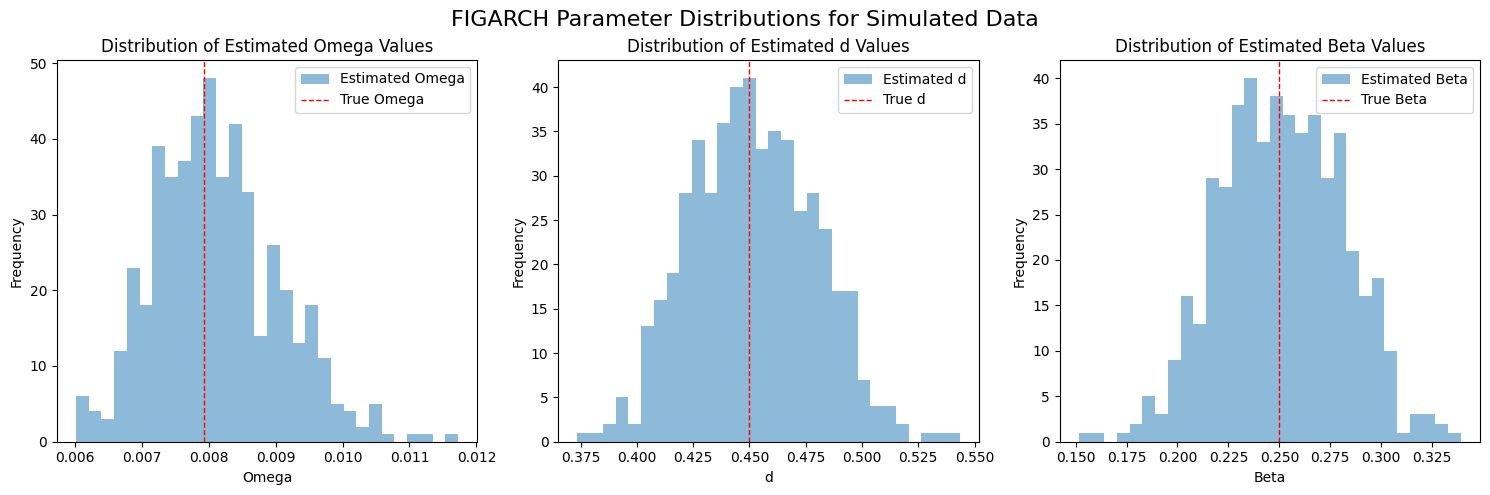

In [37]:
d_true = 0.45
b_true = 0.25
omega_true = np.array([2e-4 / 252]) * 100**2

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

plt.hist(omegas, bins=30, alpha=0.5, label='Estimated Omega')
plt.axvline(omega_true, color='red', linestyle='dashed', linewidth=1, label='True Omega')
plt.xlabel('Omega')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Omega Values')
plt.legend()    

plt.subplot(1, 3, 2)
plt.hist(ds, bins=30, alpha=0.5, label='Estimated d')
plt.axvline(d_true, color='red', linestyle='dashed', linewidth=1, label='True d')
plt.xlabel('d')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated d Values')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(betas, bins=30, alpha=0.5, label='Estimated Beta')
plt.axvline(b_true, color='red', linestyle='dashed', linewidth=1, label='True Beta')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Beta Values')
plt.legend()

plt.tight_layout()
plt.suptitle('FIGARCH Parameter Distributions for Simulated Data', fontsize=16)
plt.subplots_adjust(top=0.88)  
plt.show()

In [42]:
# get RMSE for the estimates

rmse_omega = np.sqrt(np.mean((np.array(omegas) - omega_true)**2))
rmse_d = np.sqrt(np.mean((np.array(ds) - d_true)**2))
rmse_beta = np.sqrt(np.mean((np.array(betas) - b_true)**2))

print(f"RMSE Omega: {rmse_omega:.6f}, RMSE d: {rmse_d:.6f}, RMSE Beta: {rmse_beta:.6f}")


RMSE Omega: 0.000946, RMSE d: 0.027766, RMSE Beta: 0.030451


## Empirical

In [ ]:
sgd_usd_5m = pd.read_parquet("SGD_USD_5M.parquet")  
cleaner = DataCleaner_SGD(sgd_usd_5m, start_hr=2, end_hr=18, unit_test=False) # replace US SG holidays when needed
realised_variance = cleaner.clean_data()
daily_log_returns = pd.read_parquet("SGD_USD_Daily_matched.parquet")
N = len(daily_log_returns)

train_log_returns = daily_log_returns.iloc[:int(N * 0.5)]
test_log_returns = daily_log_returns.iloc[int(N * 0.5):]
test_realised_variance = realised_variance.iloc[int(N * 0.5):]
initial_params = [1e-4, 0.35, 0.25] # omega, d, beta
H = 20
M = 1000

In [56]:
figarch_forecaster = FIGARCH_Forecaster(
    train_data=train_log_returns.values.flatten(),
    test_data=test_log_returns.values.flatten(),
    test_realised_variance=test_realised_variance.values.flatten(),
    initial_params=initial_params,
    p=1,
    q=0,
    H=H, 
    M=M, 
    scale=100,
    percent_space=True)

omega, d, beta, sigma2_prev = figarch_forecaster.estimate_figarch()

mse, R2, realised_vol_H_forecasts, realised_vol_H_true = figarch_forecaster.forecast_figarch()

Estimated parameters: omega=0.009298443394519748, d=0.4538, beta=0.3909
Final log-likelihood = 1666.9120
MSE: 0.9633802420215465, R2: 0.251514


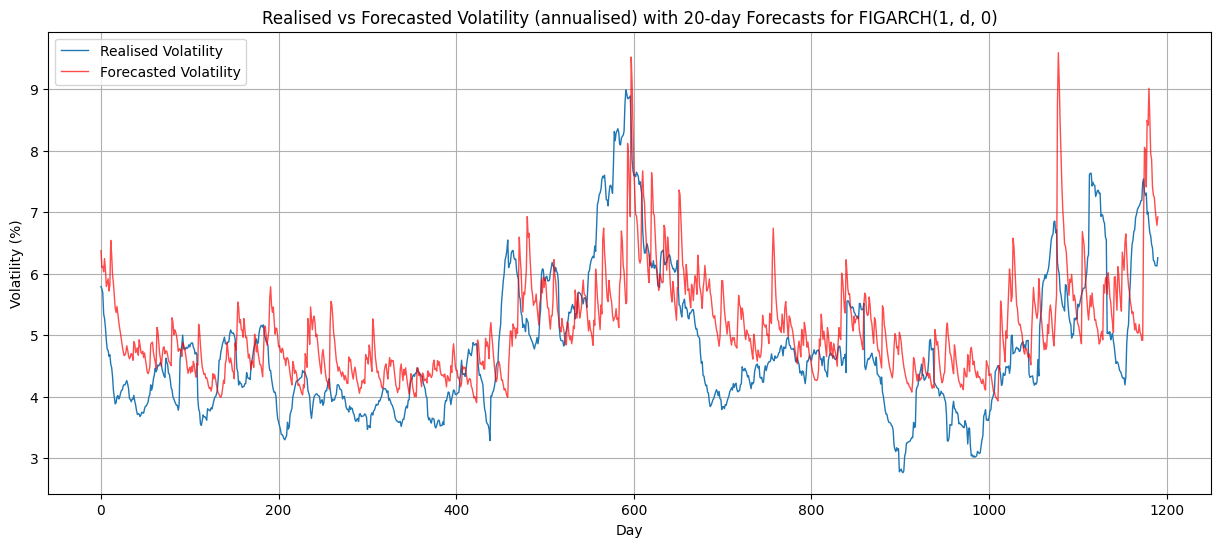

In [57]:
plt.figure(figsize=(15, 6))
plt.plot(realised_vol_H_true , color = 'tab:blue',label='Realised Volatility', linewidth=1)
plt.plot(realised_vol_H_forecasts , color = 'red', label='Forecasted Volatility', linestyle='-', linewidth=1, alpha=0.7)
plt.xlabel('Day')
plt.ylabel('Volatility (%)')
plt.title(f'Realised vs Forecasted Volatility (annualised) with {H}-day Forecasts for FIGARCH(1, d, 0)')
plt.grid()
plt.legend()
